In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
import PlaceCellAnalysis as pc
import pickle

os.sys.path.append('../')
import utilities as u
import preprocessing as pp
import matplotlib.gridspec as gridspec
import SimilarityMatrixAnalysis as sm


%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
df = pp.load_session_db()


df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
tracks = 'TwoTower_foraging|FreqMorph_Timeout|FreqMorph_Decision|TwoTower_noTimeout|TwoTower_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [4]:
def run_single_session(sess,binned=False):
    VRDat,C, S, A = pp.load_scan_sess(sess)
    trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
    S_trial_mat, occ_trial_mat, edges,centers = u.make_pos_bin_trial_matrices(S,VRDat['pos']._values,VRDat['tstart']._values,VRDat['teleport']._values,bin_size=10,speed=VRDat['speed']._values)

    if binned:
        effMorph = trial_info['morphs']
    else:
        effMorph = trial_info['morphs']+trial_info['bckgndJitter']+trial_info['wallJitter']+trial_info['towerJitter']
        effMorph = (effMorph+.3)/1.6
#     
    
    S_trial_mat[np.isnan(S_trial_mat)]=0
    S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,1,axis=1)
    
    lr_bin = np.zeros(S_trial_mat.shape[:-1])
    S_tmat_norm = S_trial_mat/np.linalg.norm(S_trial_mat,2,axis=-1)[:,:,np.newaxis]
    for trial in range(S_trial_mat.shape[0]):
        mask0 = trial_info['morphs']==0
        mask1 = trial_info['morphs']==1
        if trial_info['morphs'][trial]==0:
            mask0[trial]=False
        elif trial_info['morphs'][trial]==1:
            mask1[trial]=False


        centroid_0 = S_trial_mat[mask0,:,:].mean(axis=0)
        centroid_0/=np.linalg.norm(centroid_0,2,axis=-1)[:,np.newaxis]

        centroid_1 = S_trial_mat[mask1,:,:].mean(axis=0)
        centroid_1/=np.linalg.norm(centroid_1,2,axis=-1)[:,np.newaxis]

        angle0 = np.diagonal(np.matmul(S_tmat_norm[trial,:,:],centroid_0.T))
        angle1 = np.diagonal(np.matmul(S_tmat_norm[trial,:,:],centroid_1.T))
        lr_bin[trial,:] = angle0/(angle1 +angle0)
#         lr_bin[trial,:]=np.log(angle1/angle0)
        
    return lr_bin, effMorph


def build_matrix(mouse_list,first_sess=5,binned=False):
    
    firstSess = u._first_sess_gen(mouse_list,first_sess)
    
    for m,(mouse,f_ind) in enumerate(zip(mouse_list,firstSess)):
    
        print(mouse)
        df_mouse = df[df['MouseName'].str.match(mouse)]
        for i, sess_ind in enumerate(range(f_ind,df_mouse.shape[0])):
            _lr,_em = run_single_session(df_mouse.iloc[sess_ind],binned=binned)
            if (m==0) and (i==0):
                lr,em = _lr,_em
            else:
                lr,em = np.concatenate((lr,_lr),axis=0),np.concatenate((em,_em),axis=0)

    return lr,em

In [12]:
lr_rare,em_rare = build_matrix(['4139265.5','4139265.4','4139265.3','4222168.2'],binned=True, first_sess=[5,5,5,3])
lr_fam,em_fam = build_matrix(['4222153.2','4222153.1','4222153.3','4222174.1','4222154.1'],first_sess=4,binned=True)

4139265.5
num aberrant ttls 0.0
34737 (34737,) (34737, 21) 113863
(113863,) (113863, 21)
frame diff 0
num aberrant ttls 0.0
36018 (36018,) (36018, 21) 118606
(118606,) (118606, 21)
frame diff 0
num aberrant ttls 0.0
40272 (40272,) (40272, 21) 133982
(133982,) (133982, 21)
frame diff 0
num aberrant ttls 0.0
36659 (36659,) (36659, 21) 120387
(120387,) (120387, 21)
frame diff 0
num aberrant ttls 0.0
36583 (36583,) (36583, 21) 124384
(124384,) (124384, 21)
frame diff 0
4139265.4
num aberrant ttls 0.0
30897 (30897,) (30897, 21) 102093
(102093,) (102093, 21)
frame diff 0
num aberrant ttls 0.0
29023 (29023,) (29023, 21) 95160
(95160,) (95160, 21)
frame diff 0
num aberrant ttls 0.0
31116 (31116,) (31116, 21) 102131
(102131,) (102131, 21)
frame diff 0
num aberrant ttls 0.0
31932 (31932,) (31932, 21) 105228
(105228,) (105228, 21)
frame diff 0
num aberrant ttls 0.0
30493 (30493,) (30493, 21) 100982
(100982,) (100982, 21)
frame diff 0
num aberrant ttls 0.0
32084 (32084,) (32084, 21) 105601
(105601

In [5]:
def plot_binned_lar(lr,em):
    em_edges = [0,.25,.5,.75,1.]
#     em_dig = np.digitize(em,em_edges,right=False)


    f,ax = plt.subplots()
    for b in em_edges:
        print(b)
        mask = em == b
        mu =lr[mask,:].mean(axis=0)
        sem = sp.stats.sem(lr[mask,:],axis=0)
        ax.fill_between(np.arange(lr.shape[1]),mu-sem,y2=mu+sem,color=plt.cm.cool(1.-b))
    return f,ax




0
0.25
0.5
0.75
1.0
0
0.25
0.5
0.75
1.0


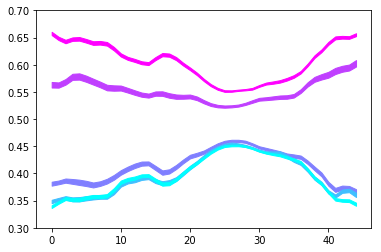

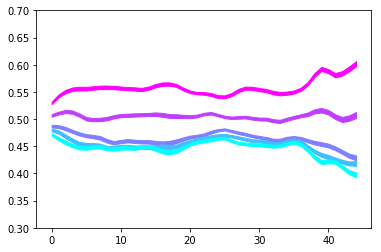

In [19]:
f_rare,ax_rare = plot_binned_lar(lr_rare,em_rare)
f_fam,ax_fam = plot_binned_lar(lr_fam,em_fam)
ax_rare.set_ylim([0.3,.7])
ax_fam.set_ylim([.3,.7])
f_rare.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\allrare_rtsf.pdf",format='pdf')
f_fam.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_Manuscript\\Figures\\allfam_rtlsf.pdf",format='pdf')

In [6]:
def plot_single_sess(lr_bin,em,mouse,date):
    f,ax = plt.subplots()
    for t in range(lr_bin.shape[0]):    
        ax.plot(lr_bin[t,:],c=plt.cm.cool(1-em[t]),alpha=.3)
    f.savefig(os.path.join("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures","%s_%s_rtsf.pdf" % (mouse,date)),format='pdf')
    

num aberrant ttls 0.0
36018 (36018,) (36018, 21) 118606
(118606,) (118606, 21)


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


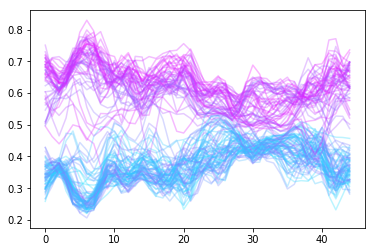

In [7]:
mouse = '4139265.5'
date = '21_02_2019'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
lr_bin, effMorph = run_single_session(sess)
plot_single_sess(lr_bin,effMorph,mouse,date)


num aberrant ttls 0.0
32644 (32644,) (32644, 21) 106559
(106559,) (106559, 21)
frame diff 0


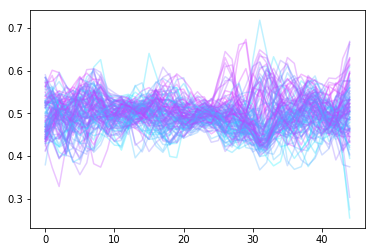

In [13]:
mouse = '4222154.1'
date = '15_04_2019'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
lr_bin, effMorph = run_single_session(sess)
plot_single_sess(lr_bin,effMorph,mouse,date)

num aberrant ttls 0.0
22270 (22270,) (22270, 21) 63586
(63586,) (63586, 21)
frame diff 0


C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


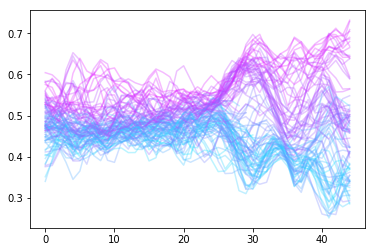

In [23]:
mouse = '4222157.4'
date = '19_06_2019'
df_mouse = df[df['MouseName'].str.match(mouse)]
sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
lr_bin, effMorph = run_single_session(sess)
plot_single_sess(lr_bin,effMorph,mouse,date)

MouseName                                                4222169.4
DateFolder                                              14_08_2019
SessionNumber                                                    2
Track                                             TwoTower_Timeout
RewardCount                                                     49
Imaging                                                          1
ImagingRegion                                                  CA1
DateTime                                       2019-08-14 00:00:00
data file        G:\My Drive\VR_Data\TwoTower\4222169.4\14_08_2...
scanfile                                                      None
scanmat          G:\My Drive\2P_Data\TwoTower\4222169.4\14_08_2...
s2pfolder        G:\My Drive\2P_Data\TwoTower\4222169.4\14_08_2...
Name: 2434, dtype: object
num aberrant ttls 0.0
34589 (34589,) (34589, 21) 98774
frame diff 0


C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


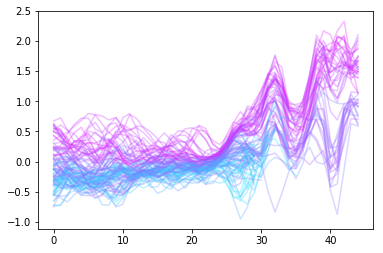

In [8]:
mouse = '4222169.4'
# date = '19_06_2019'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse
sess = df_mouse.iloc[-1]
date = sess.DateFolder
print(sess)

# sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
lr_bin, effMorph = run_single_session(sess)
plot_single_sess(lr_bin,effMorph,mouse,date)

num aberrant ttls 0.0
33495 (33495,) (33495, 21) 95693
frame diff 0


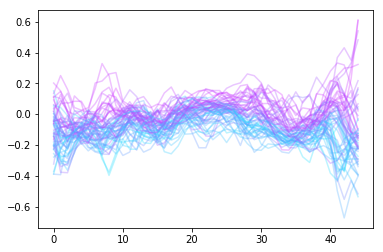

In [11]:
mouse = '4222169.1'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse
sess = df_mouse.iloc[-3]

# sess = df_mouse[df_mouse['DateFolder'].str.match(date)].iloc[0]
lr_bin, effMorph = run_single_session(sess)
plot_single_sess(lr_bin,effMorph,mouse,date)